## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means
from scipy import signal
from tqdm import tqdm
import pandas as pd
from scipy.stats.stats import pearsonr 

np.random.seed(110**2)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [3]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesGL905/2firstcomponent.npy', allow_pickle=True) #### PATH TO CHANGE ####
times = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesGL905/readyforwPCA_epoc.npy')                          #### PATH TO CHANGE ####

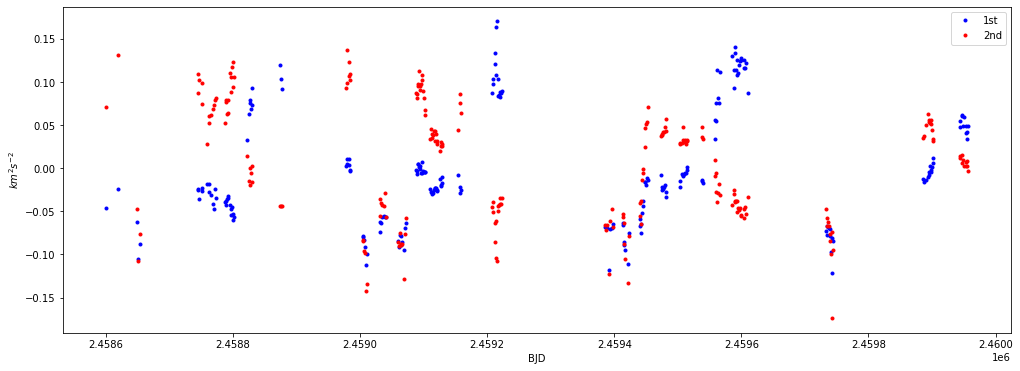

In [4]:
plt.figure(figsize=(17, 6))
plt.plot(times, eigen2vectors[0], 'b.', label='1st')
plt.plot(times, eigen2vectors[1], 'r.', label='2nd')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
#plt.plot(times[:-1], eigen2vectors[3], 'r.')

plt.show()

## Periodograms
### 1st component

Peak frequency = 
366.65034866262533


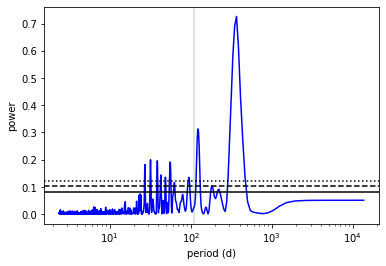

In [5]:
frequency, power = LombScargle(times, eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')
plt.axvline(110, c='g', alpha = 0.2)
plt.show()

$P_{rot} = 110  \pm 6 d$ according Carmenes

### 2nd component

Peak frequency = 
180.8808386735618


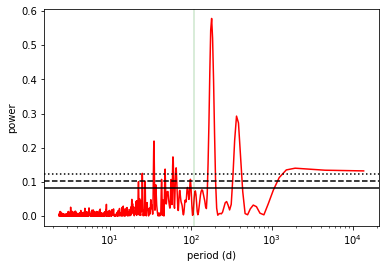

In [7]:
frequency, power = LombScargle(times, eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')
plt.axvline(110, c='g', alpha = 0.2)
plt.show()

## First component GP

Just to recall the GP uses a Quasi-Periodic covariance function that is build that way:


$K_{ij} = \eta_1^2 \, \exp \left[- \frac{(t_i - t_j)^2}{2 \eta_2^2} - \frac{2 }{\eta_4^2} \sin^2 \left( \frac{\pi (t_i - t_j)}{\eta_3} \right) \right] + Jitter$ 

In [8]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times)-np.min(times)))


0.5834964972700772
0.06632568559514129
13566.062900517136


For the Prior distribution, I use : 

$\eta_1 : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

$\eta_2 : \mathcal{LU}\left( 1 , 10 \times t_{total} \right)$

$\eta_3 : \mathcal{N}\left( P , 0.1 \right)$

$\eta_4 : \mathcal{LU}\left( 0.1, 5 \right)$

$Jitter : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

In [9]:
#Priors
n_eta1 = ModifiedLogUniform(0.07, 0.6)
n_eta2 = stats.loguniform(1, 12565)
n_eta3 = stats.norm(loc=110, scale=6)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.07, 0.6)

In [10]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [9]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [10]:
ndim = priors().size 
nwalkers = 2*ndim

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [11:18<00:00, 14.75it/s]


State([[5.97704284e-02 2.35939155e+01 1.17162010e+02 3.13983874e+00
  1.13613541e-02]
 [7.25963873e-02 8.14954681e+01 1.13043865e+02 1.21063739e+00
  1.06921331e-02]
 [6.53720936e-02 2.87855178e+01 1.05781653e+02 1.52121175e+00
  1.06340526e-02]
 [7.56851925e-02 2.07047145e+01 1.04851597e+02 2.59696403e+00
  1.22188280e-02]
 [5.65445369e-02 3.94510249e+01 1.07241770e+02 1.46420038e+00
  1.15619199e-02]
 [5.50097979e-02 6.81696059e+01 1.08540005e+02 1.00949118e+00
  1.10998814e-02]
 [6.78923765e-02 7.05167942e+01 1.15502100e+02 1.05280814e+00
  1.11476659e-02]
 [5.57840340e-02 2.27748480e+01 9.27376095e+01 1.70745001e+00
  1.12268232e-02]
 [5.73929008e-02 1.82502311e+01 1.19294780e+02 3.55761038e+00
  1.09310103e-02]
 [6.49447506e-02 8.56198606e+01 1.07692033e+02 1.30483394e+00
  1.08855310e-02]], log_prob=[626.77707914 629.67943495 630.26945325 625.55720348 629.45426265
 629.88209282 629.72962186 626.37981035 628.69036782 629.29322213], blobs=None, random_state=('MT19937', array([16756

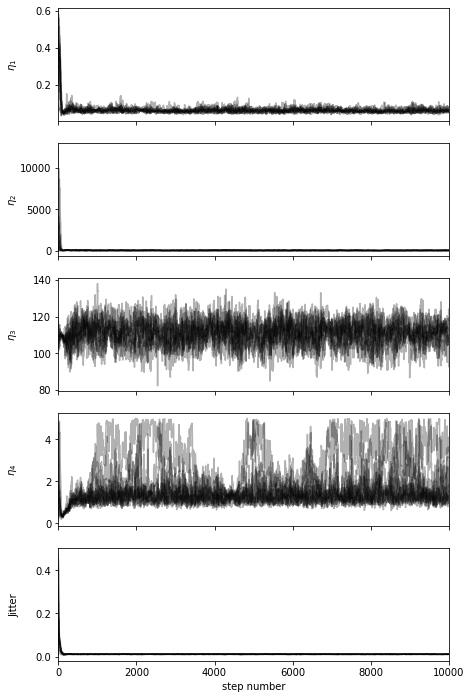

In [12]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

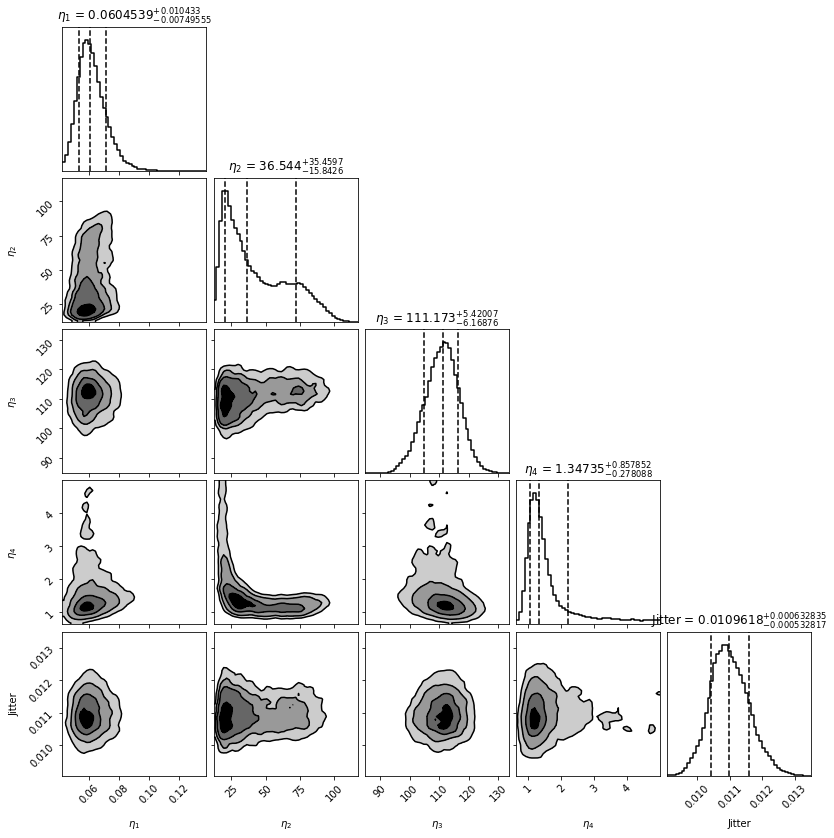

In [13]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

In [14]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

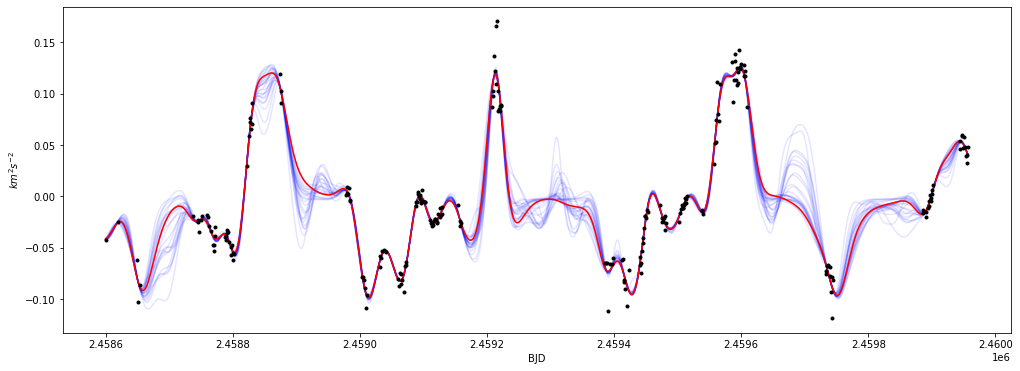

In [15]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times), np.max(times), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

100%|██████████| 15/15 [02:03<00:00,  8.22s/it]


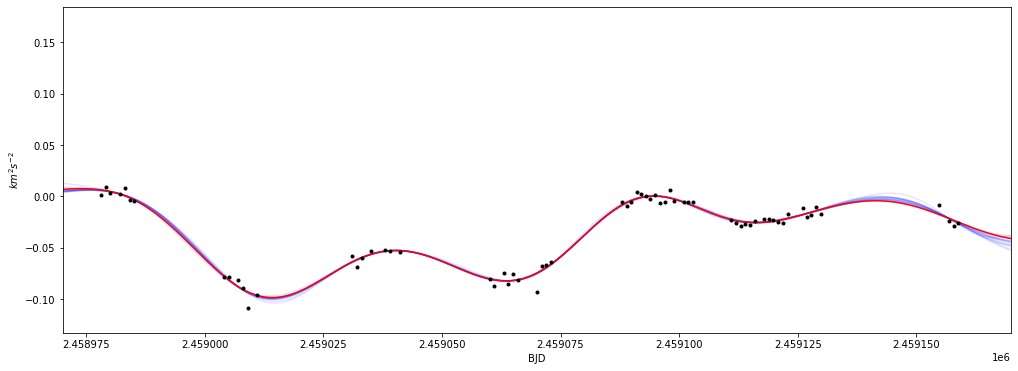

In [16]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times), np.max(times), 10000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlim([-30+2459000, 170+2459000])
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

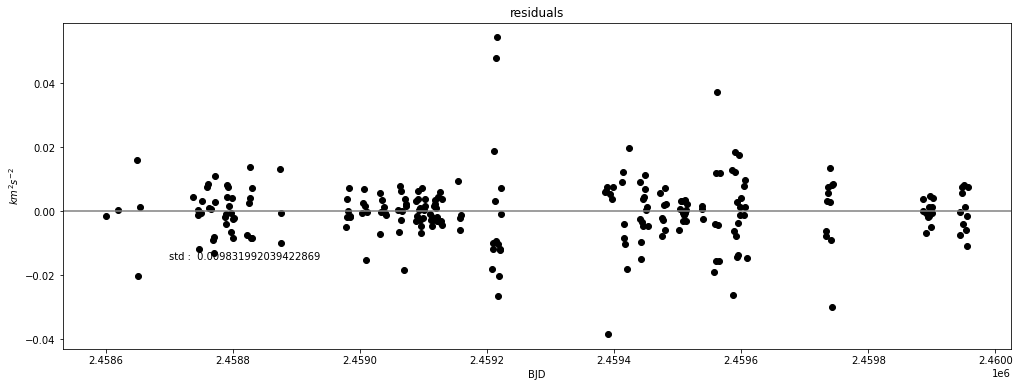

In [17]:
y_sample = Display(Hfit, times)

residuals = eigen2vectors[0] - y_sample
plt.figure(figsize=(17, 6))
plt.plot(times, residuals, 'ok')
plt.axhline(y=0, c='grey')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, -0.015) )
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

# Comparison with $B_{l}$  

In [11]:
times_B, Bl, dBl = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/Gl_905/GL905_blong_lsd.rdb',
                   usecols=(0,1,2),skiprows=0, dtype=str, unpack=True)

times_B = np.array(times_B.astype(float))
Bl = np.array(Bl.astype(float))
dBl = np.array(dBl.astype(float))

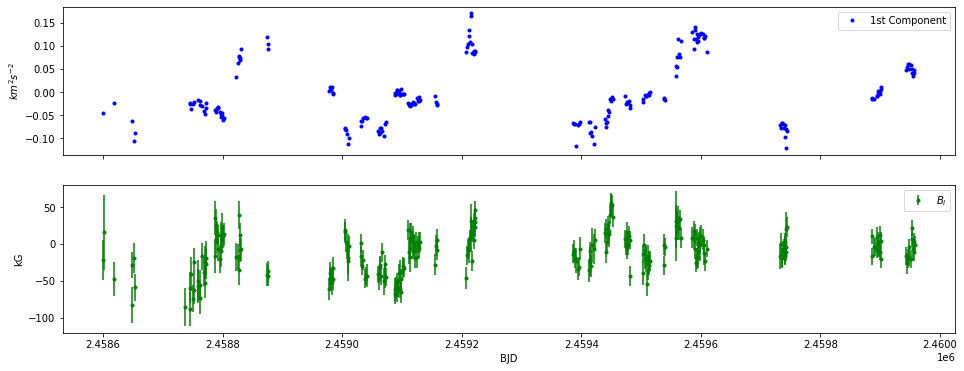

In [12]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
plt.plot(times, eigen2vectors[0], 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)


# share x and y
ax3 = plt.subplot(212, sharex=ax1)
plt.errorbar(times_B, Bl, yerr=dBl, fmt='.g', label='$B_l$')
plt.xlabel('BJD')
plt.ylabel('kG')
plt.legend()
plt.show()


Peak frequency = 
106.8980571853481


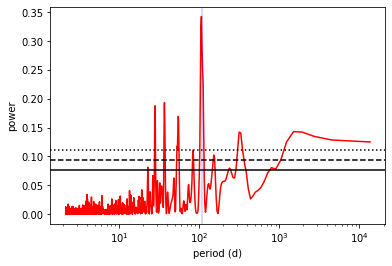

In [14]:
frequency, power = LombScargle(times_B, Bl, dBl).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_B, Bl, dBl)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')
plt.axvline(110, c='b', alpha = 0.2)


plt.show()

### $B_l$ GP

In [15]:
print(2*(np.max(Bl)- np.min(Bl)))
print(np.std(Bl))
print(10*(np.max(times_B)-np.min(times_B)))

286.40659999999997
27.17645070521019
13576.053262539208


In [16]:
#Priors
n_eta1 = ModifiedLogUniform(26, 260)
n_eta2 = stats.loguniform(1, 10000)
n_eta3 = stats.norm(loc=110, scale=6)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.01, 2)

def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(Bl))
    gpOBJ = process.GP(kernel,mean,times_B,Bl, yerr = dBl)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [17]:
ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [08:20<00:00, 19.98it/s]


State([[2.10655298e+01 1.32966471e+02 1.08892441e+02 7.94770817e-01
  3.55395297e-02]
 [2.14263124e+01 1.67953234e+02 1.07322909e+02 1.08872940e+00
  6.75614729e-01]
 [2.46379599e+01 1.83315270e+02 1.12730867e+02 7.54494401e-01
  7.22285945e-02]
 [2.10838474e+01 1.41365108e+02 1.15396859e+02 8.16240537e-01
  3.46689906e-03]
 [1.76879705e+01 1.91007661e+02 1.07645932e+02 4.62983704e-01
  3.88299442e-01]
 [1.94084675e+01 1.48307477e+02 1.08688629e+02 9.98807745e-01
  2.80436478e-01]
 [2.03459763e+01 1.50609255e+02 1.06282483e+02 9.06926113e-01
  2.80584732e-02]
 [2.06150126e+01 2.18261248e+02 1.08591151e+02 4.81921070e-01
  1.34158339e-01]
 [1.76217245e+01 1.46684186e+02 1.11448964e+02 9.20781603e-01
  6.80530443e-03]
 [1.51809748e+01 1.68698986e+02 1.12454010e+02 5.66990607e-01
  3.35113569e-01]], log_prob=[-1070.96791679 -1075.0999226  -1073.12617514 -1070.41375458
 -1075.43458576 -1073.64244121 -1071.57431705 -1073.58062324
 -1070.96378536 -1075.61682308], blobs=None, random_state=('M

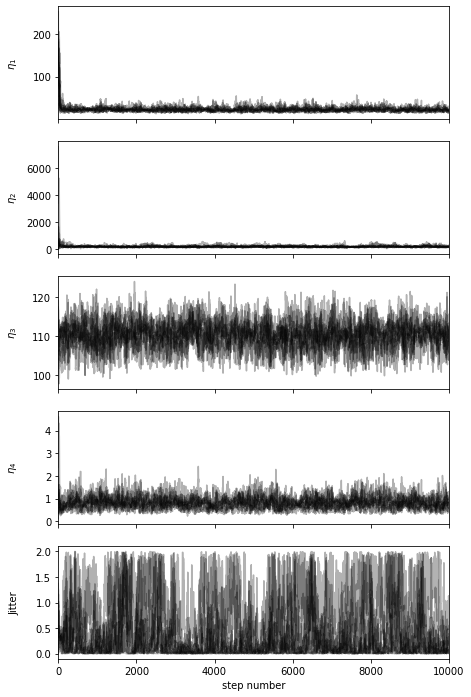

In [18]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

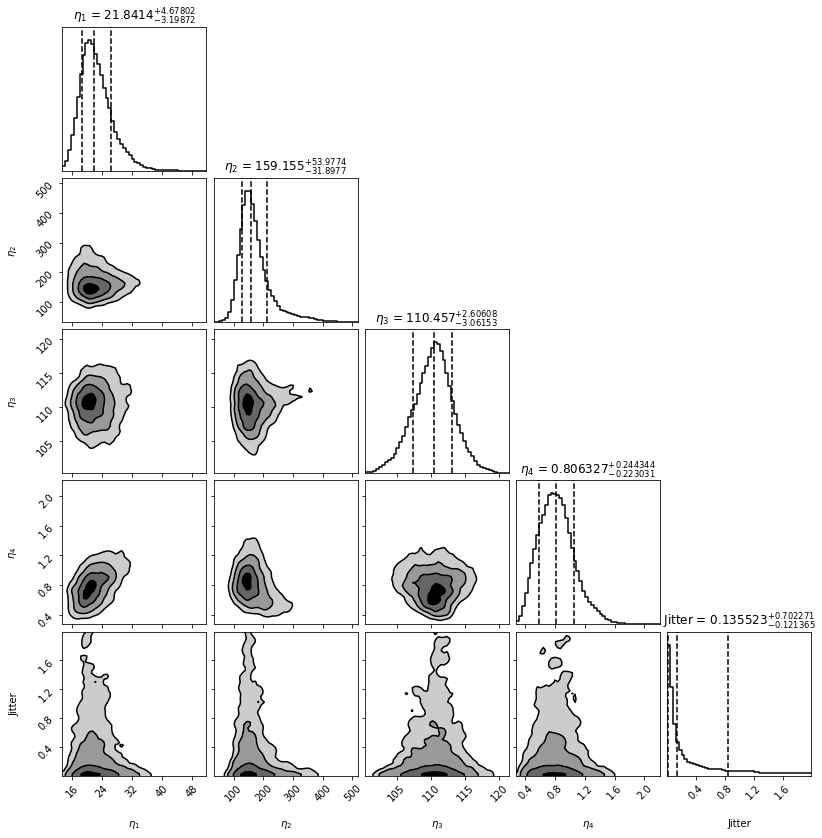

In [19]:
#corner plot
flat_samples = sampler.get_chain(discard=2000, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

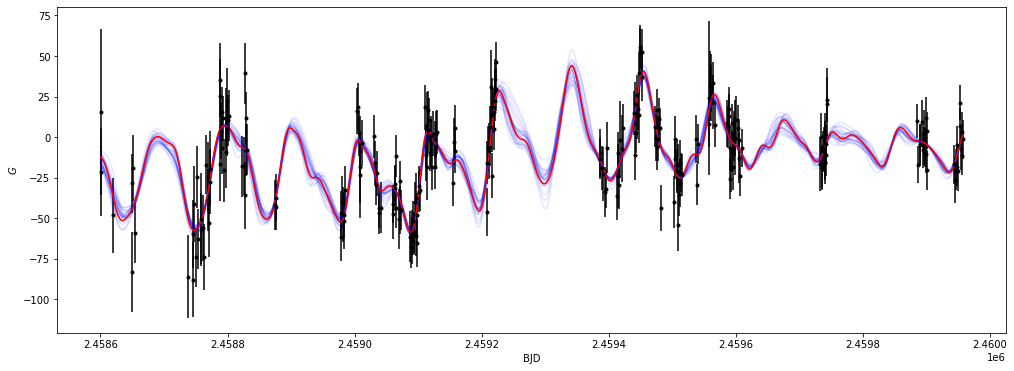

In [20]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(Bl))
    gpOBJ = process.GP(kernel,mean,times_B,Bl,yerr = dBl)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

plt.figure(figsize=(17, 6))
tplot = np.linspace(np.min(times_B), np.max(times_B), 1000)

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_B, Bl, dBl, fmt='k.')
plt.xlabel('BJD')
plt.ylabel('$G$')
plt.show()

100%|██████████| 15/15 [00:03<00:00,  4.37it/s]


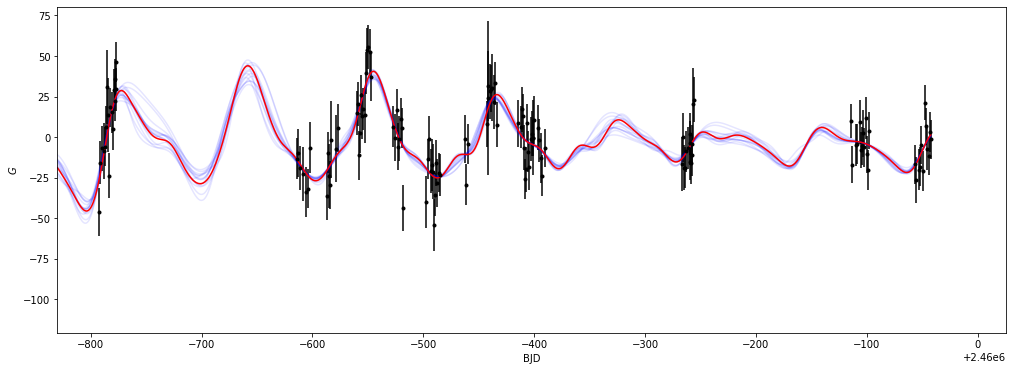

In [21]:
plt.figure(figsize=(17, 6))
tplot = np.linspace(170+2459000, np.max(times_B), 1000)

for s in tqdm(range(15)):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot, Display(Hfit, tplot), 'r')
plt.errorbar(times_B, Bl, dBl, fmt='k.')
plt.xlabel('BJD')
plt.ylabel('$G$')
plt.xlim([170+2459000, None])
plt.show()

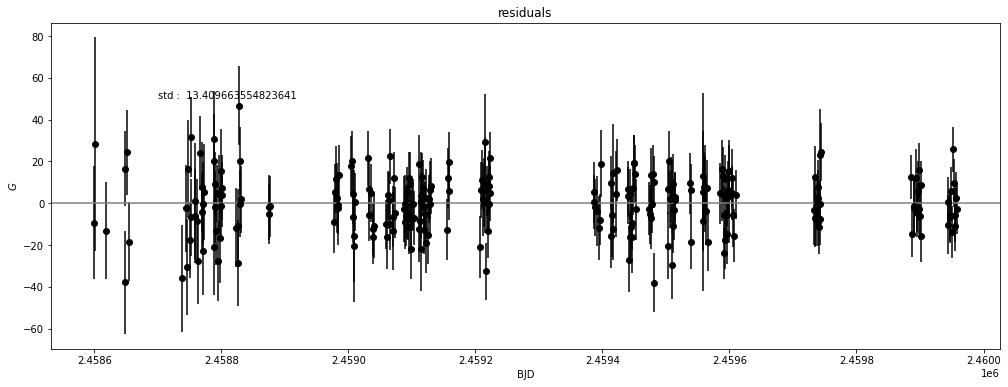

In [24]:
y_sample = Display(Hfit, times_B)

residuals = Bl - y_sample
plt.figure(figsize=(17, 6))
plt.errorbar(times_B, residuals, dBl, fmt='ok')
plt.axhline(y=0, c='grey')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, 50) )
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$G$')
plt.show()

## Correlation /w W1
### Set on the Same Times

In [25]:
i, j = 0, 0
W1 = eigen2vectors[0]
while i < len(times) and j < len(times_B):
    diff = times[i] - times_B[j]
    if np.abs(diff) < 0.5:
        i += 1
        j += 1
    elif diff > 0.5:
        print('W', times[i], 'B', times_B[j])
        print('point remove in B')
        times_B = np.delete(times_B, j)
        Bl = np.delete(Bl, j)
        dBl = np.delete(dBl, j)
    elif diff < -0.5:
        print('W', times[i], 'B', times_B[j])
        print('point remove in W')
        times = np.delete(times, i)
        W1 = np.delete(W1, i)

times = times[:i]
W1 = W1[:i]
times_B = times_B[:j]
Bl = Bl[:j]
dBl = dBl[:j]

W 2458619.0964014735 B 2458601.134732959
point remove in B
W 2458651.039451547 B 2458649.131221771
point remove in B
W 2458745.0326072276 B 2458737.893469755
point remove in B
W 2458758.9743976863 B 2458752.904925017
point remove in B
W 2458761.9066641456 B 2458758.976590294
point remove in B
W 2458770.895058732 B 2458770.020665302
point remove in B
W 2458788.9050774546 B 2458787.917839042
point remove in B
W 2459011.014632987 B 2459009.08887295
point remove in B
W 2459073.071992837 B 2459072.042676764
point remove in B
W 2459114.907859779 B 2459113.879125411
point remove in B
W 2459126.0396871697 B 2459122.888982558
point remove in B
W 2459222.7572387625 B 2459221.769785684
point remove in B
W 2459386.0207373663 B 2459222.777036692
point remove in B
W 2459448.030345953 B 2459446.995416965
point remove in B
W 2459507.0134710106 B 2459504.832083995
point remove in B
W 2459512.776050145 B 2459511.865088055
point remove in B
W 2459559.842519946 B 2459558.797719392
point remove in B
W 2459

In [26]:
print(times - times_B)

[-4.65661287e-10 -4.65661287e-10  7.65347709e-02  0.00000000e+00
 -4.65661287e-10 -4.65661287e-10  0.00000000e+00 -4.65661287e-10
  0.00000000e+00  0.00000000e+00  2.19260808e-03 -4.65661287e-10
  0.00000000e+00  4.65661287e-10  0.00000000e+00  0.00000000e+00
  4.65661287e-10 -4.65661287e-10  1.48695447e-02 -4.65661287e-10
 -4.65661287e-10  0.00000000e+00  0.00000000e+00 -4.65661287e-10
  4.65661287e-10 -4.65661287e-10 -4.65661287e-10  0.00000000e+00
  4.65661287e-10  0.00000000e+00  0.00000000e+00 -4.65661287e-10
  0.00000000e+00  0.00000000e+00  0.00000000e+00  4.65661287e-10
  0.00000000e+00 -4.65661287e-10 -4.65661287e-10 -4.65661287e-10
  4.65661287e-10  0.00000000e+00 -4.65661287e-10  0.00000000e+00
  4.65661287e-10  4.65661287e-10  0.00000000e+00  0.00000000e+00
 -4.65661287e-10 -4.65661287e-10  4.65661287e-10  0.00000000e+00
  1.24540748e-02  0.00000000e+00  0.00000000e+00 -4.65661287e-10
  4.65661287e-10 -4.65661287e-10 -4.65661287e-10  0.00000000e+00
 -4.65661287e-10  0.00000

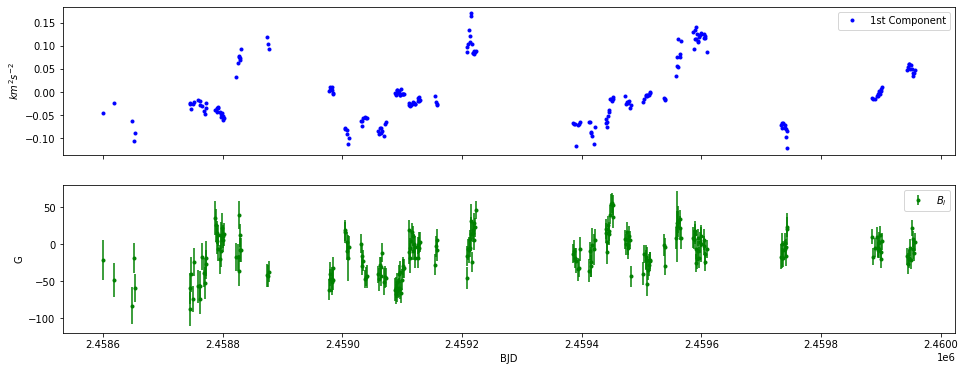

In [27]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
plt.plot(times, W1, 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)


# share x and y
ax3 = plt.subplot(212, sharex=ax1)
plt.errorbar(times_B, Bl, yerr=dBl, fmt='.g', label='$B_l$')
plt.xlabel('BJD')
plt.ylabel('G')
plt.legend()
plt.show()

In [28]:
pearsonr(W1, Bl)

(0.1828666348923543, 0.005722140809257779)